In [1]:
from pylsl import StreamInlet, resolve_stream
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft, fftfreq

## LSL Receiver

In [2]:
print("looking for an EEG stream...")
streams = resolve_stream('type', 'EEG')

# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])
data = np.array([])
while True:
    # get a new sample (you can also omit the timestamp part if you're not
    # interested in it)
    chunk, timestamps = inlet.pull_chunk()
    if timestamps:
        data = np.append(data, np.array(chunk).flatten())
    if len(data) > 1000:
        break
print(data)

looking for an EEG stream...


2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:89    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:89    INFO| netif 'enp0s31f6' (status: 4096, multicast: 1, broadcast: 2)
2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:89    INFO| netif 'wlp0s20f3' (status: 4096, multicast: 1, broadcast: 2)
2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:89    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:89    INFO| netif 'wlp0s20f3' (status: 4096, multicast: 1, broadcast: 2)
2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:102   INFO| 	IPv4 addr: 83b314f6
2023-04-13 15:24:31.307 (   0.549s) [python          ]      netinterfaces.cpp:89    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-04-13 15

[-0.86575824 -0.5447697   1.33114111 ...  0.21265946  0.07382332
  0.27953941]


## Plot Received Data (Discrete Time)

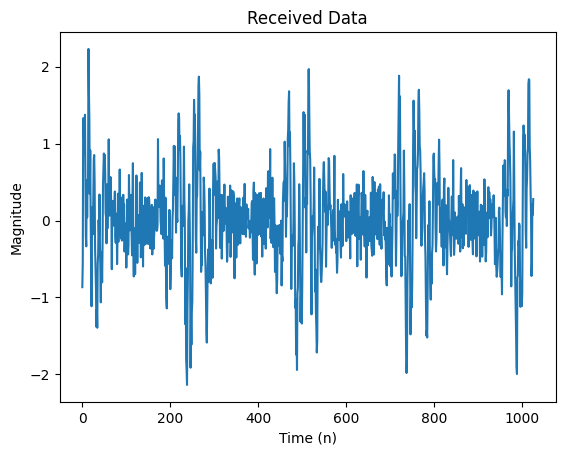

In [3]:
t = [*range(len(data))]

plt.title('Received Data')
plt.ylabel('Magnitude')
plt.xlabel('Time (n)')
plt.plot(t, data)

## Time to do FFT on the data

### Note:
The signal does not have 

/home/anderson/miniconda3/envs/crux/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


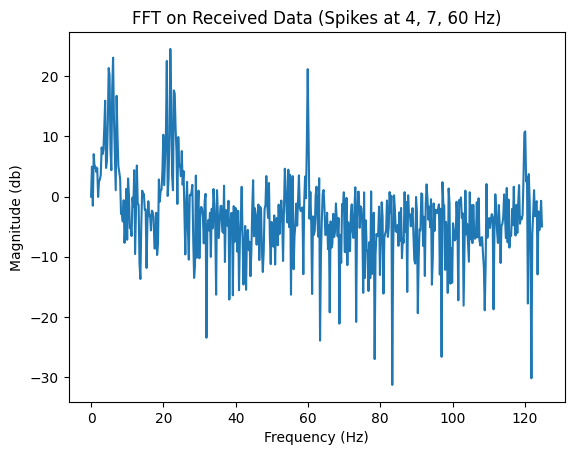

In [4]:
# Sample count
N = len(data)
# Sampling rate
fs = 250

# Sample spacing (inverse of sampling rate)
df = 1/fs

'''
FFT and frequency time scale
Halve the frequency domain due to real-time signal conjugate symmetry
'''
yf = fft(data)[:N//2]
xf = fftfreq(N, df)[:N//2]

'''
Convert power signal to normalized decibel
'''
yf_plot = 20*np.log10(np.abs(yf)/np.max(yf))
yf_plot -= yf_plot[0]

plt.title('FFT on Received Data (Spikes at 4, 7, 60 Hz)')
plt.ylabel('Magnitude (db)')
plt.xlabel('Frequency (Hz)')
plt.plot(xf, yf_plot)

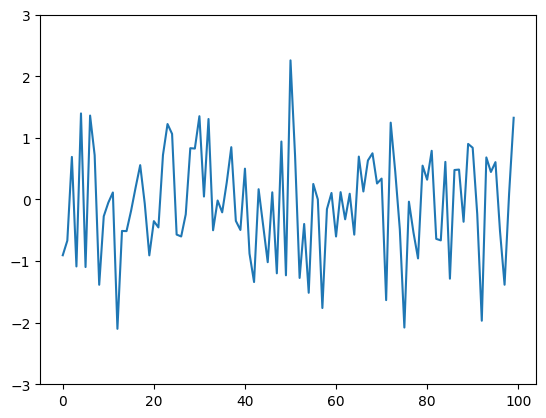

In [5]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

m = 100
n = 100
matrix = np.random.normal(0, 1, size=(m, n))

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(m):
    ax.clear()
    ax.plot(matrix[i, :])
    ax.set_ylim(-3, 3)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)


KeyboardInterrupt: 

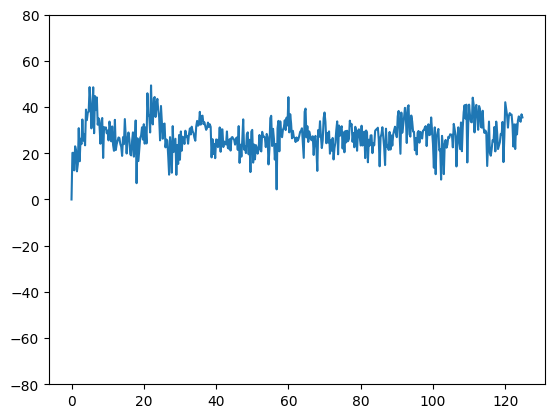

In [2]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from pylsl import StreamInlet, resolve_stream
from scipy.fft import fft, ifft, fftfreq

%matplotlib inline

print("looking for an EEG stream...")
streams = resolve_stream('type', 'EEG')

fig = plt.figure()
ax = fig.add_subplot(111)

# create a new inlet to read from the stream
inlet = StreamInlet(streams[0])
data = np.array([])
while True:
    # get a new sample (you can also omit the timestamp part if you're not
    # interested in it)
    chunk, timestamps = inlet.pull_chunk()
    if timestamps:
        data = np.append(data, np.array(chunk).flatten())
    if len(data) > 1000:
        data = data[-1000:]

        # Sample count
        N = len(data)
        # Sampling rate
        fs = 250

        # Sample spacing (inverse of sampling rate)
        df = 1/fs

        '''
        FFT and frequency time scale
        Halve the frequency domain due to real-time signal conjugate symmetry
        '''
        yf = fft(data)[:N//2]
        xf = fftfreq(N, df)[:N//2]

        '''
        Convert power signal to normalized decibel
        '''
        yf_plot = 20*np.log10(np.abs(yf)/np.max(yf))
        yf_plot -= yf_plot[0]

        ax.clear()
        ax.plot(xf, yf_plot)
        ax.set_ylim(-80, 80)
        display(fig)
        clear_output(wait=True)
    # plt.pause(0.1)
